## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 15
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/e' + str(i))

print(models, model_names)

inputs = ['a', 'b', 'c', 'd', 'e', 'f']
target = ['g']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512]] ['temp/e0', 'temp/e1', 'temp/e2', 'temp/e3', 'temp/e4', 'temp/e5', 'temp/e6', 'temp/e7', 'temp/e8', 'temp/e9', 'temp/e10', 'temp/e11', 'temp/e12', 'temp/e13', 'temp/e14']


In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/e0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.2519 - mean_squared_error: 1.2519 - val_loss: 1.0577 - val_mean_squared_error: 1.0577

Epoch 00001: val_loss improved from inf to 1.05773, saving model to temp/e0
Epoch 2/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.0640 - mean_squared_error: 1.0640 - val_loss: 1.0453 - val_mean_squared_error: 1.0453

Epoch 00002: val_loss improved from 1.05773 to 1.04529, saving model to temp/e0
Epoch 3/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.0621 - mean_squared_error: 1.0621 - val_loss: 1.0636 - val_mean_squared_error: 1.0636

Epoch 00003: val_loss did not improve from 1.04529
Epoch 4/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.0636 - mean_squared_error: 1.0636 - val_loss: 1.0911 - val_mean_squared_error: 1.0911

Epoch 00004: val_loss did not improve from 1.04529
Epoch 00004:

20000/20000 [==============================] - 31s 2ms/step - loss: 1.0587 - mean_squared_error: 1.0587 - val_loss: 1.0406 - val_mean_squared_error: 1.0406

Epoch 00007: val_loss did not improve from 1.03704
Epoch 8/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.0522 - mean_squared_error: 1.0522 - val_loss: 1.0516 - val_mean_squared_error: 1.0516

Epoch 00008: val_loss did not improve from 1.03704
Epoch 00008: early stopping
temp/e12
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 32s 2ms/step - loss: 1.2550 - mean_squared_error: 1.2550 - val_loss: 1.0643 - val_mean_squared_error: 1.0643

Epoch 00001: val_loss improved from inf to 1.06428, saving model to temp/e12
Epoch 2/20
20000/20000 [==============================] - 31s 2ms/step - loss: 1.0708 - mean_squared_error: 1.0708 - val_loss: 1.0670 - val_mean_squared_error: 1.0670

Epoch 00002: val_loss did not improve from 1.06428
Epoch 3/20
20000/20000

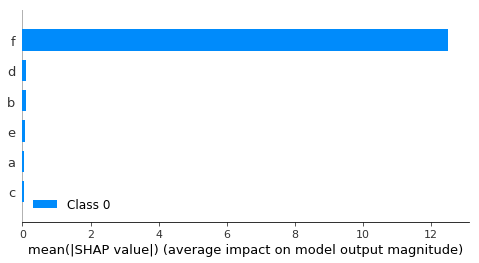

0 1


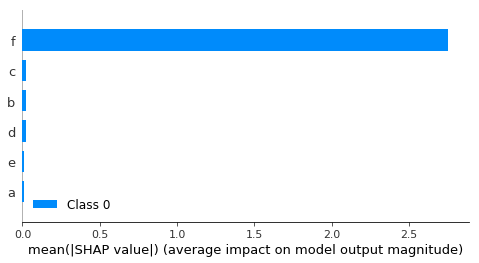

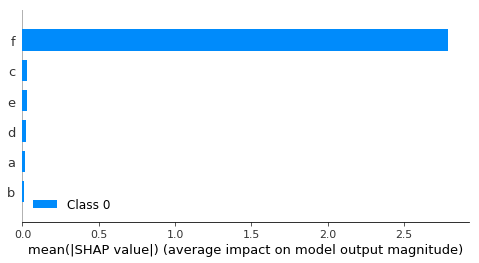

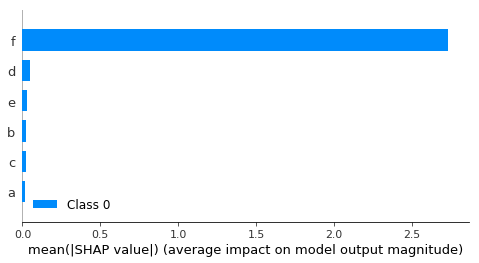

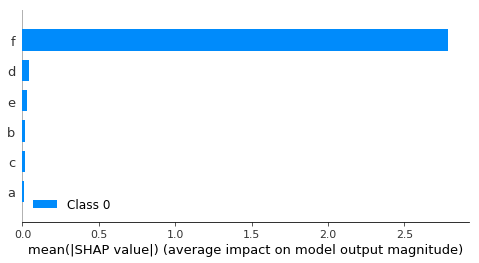

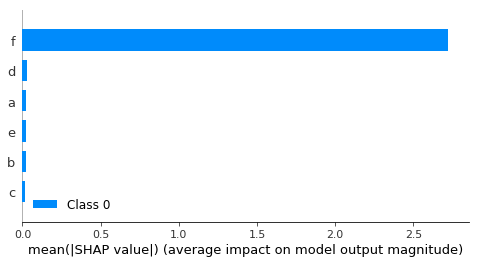

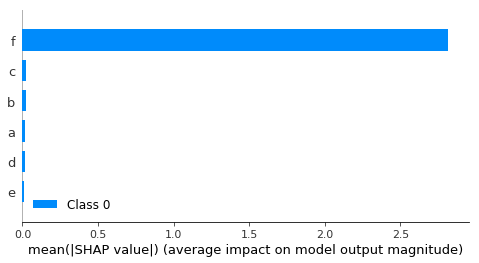

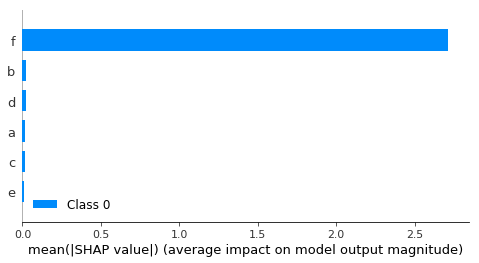

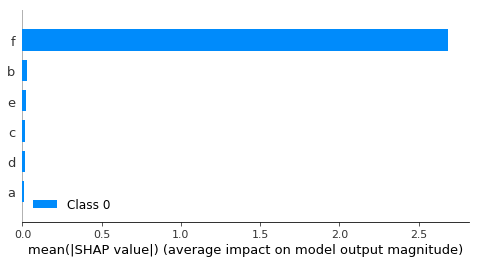

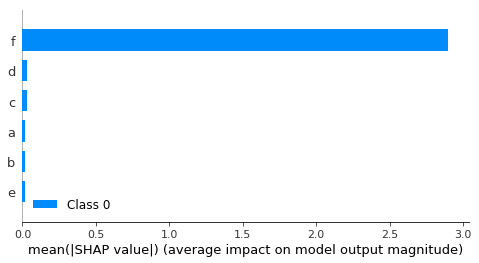

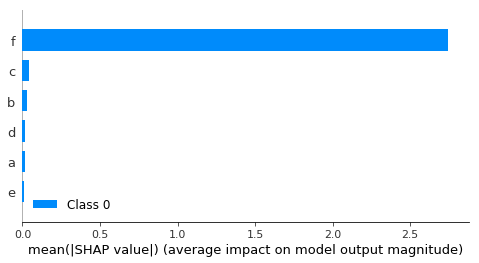

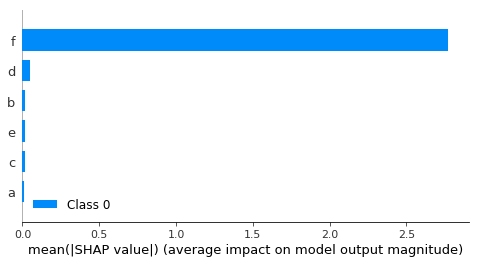

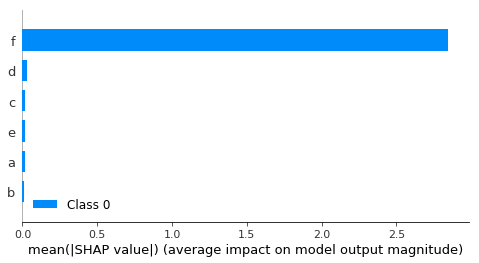

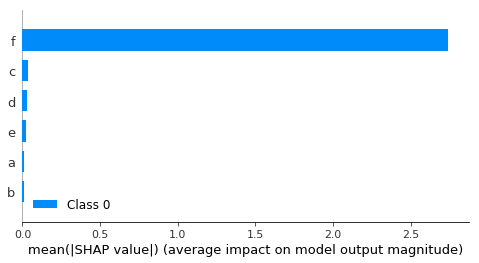

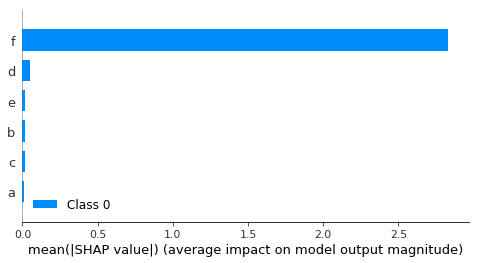

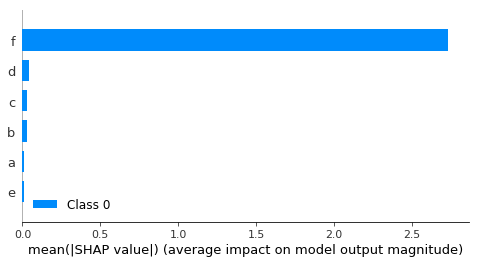

0 2


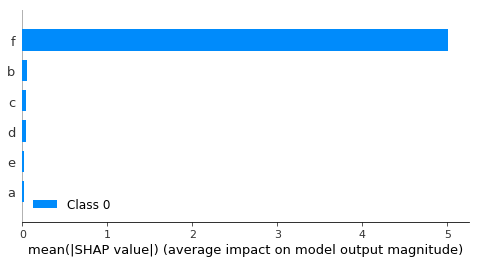

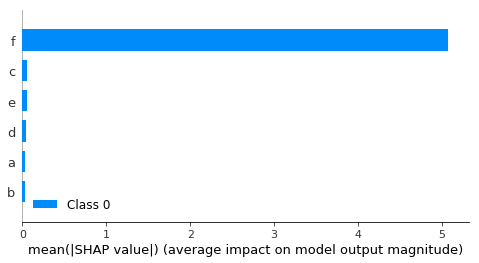

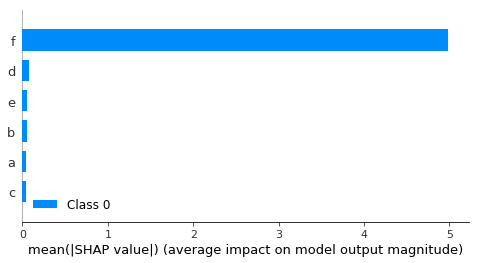

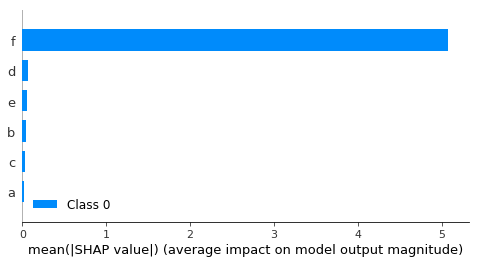

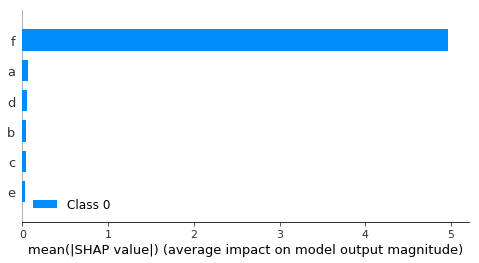

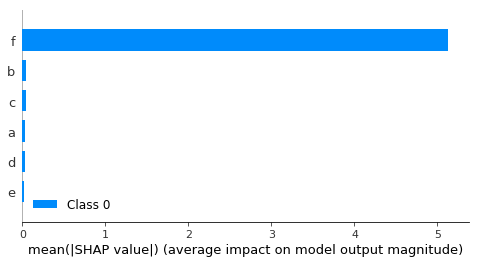

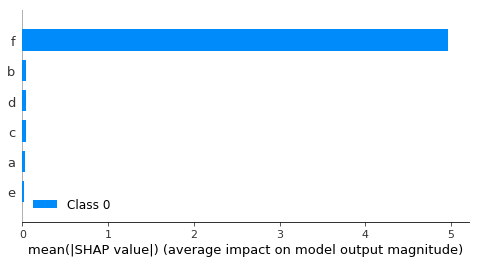

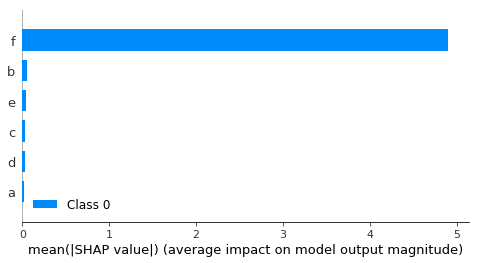

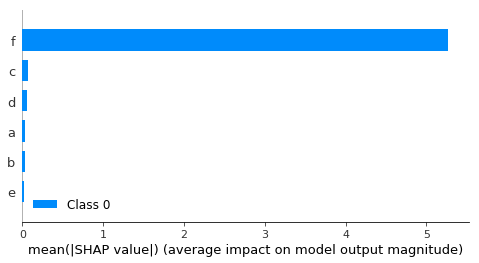

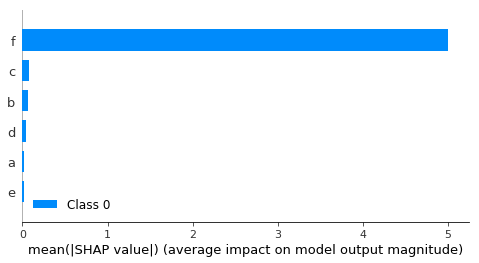

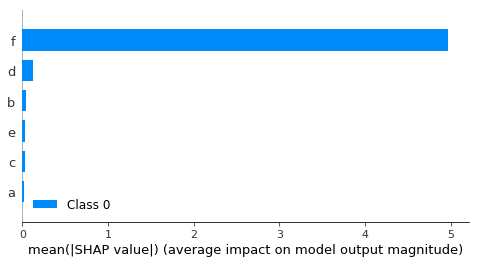

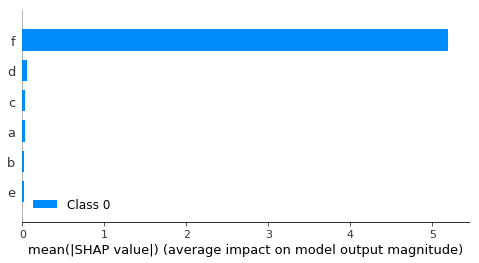

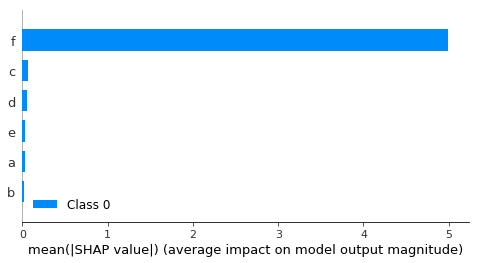

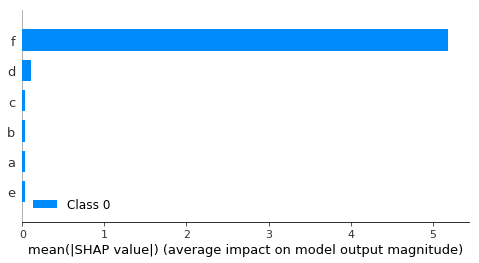

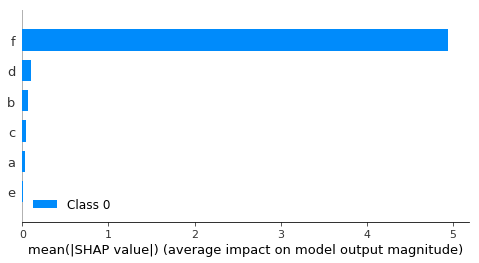

1 1


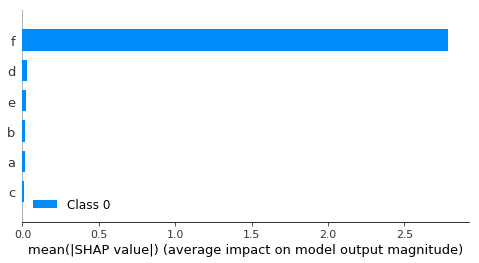

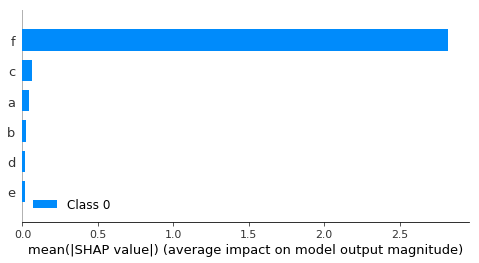

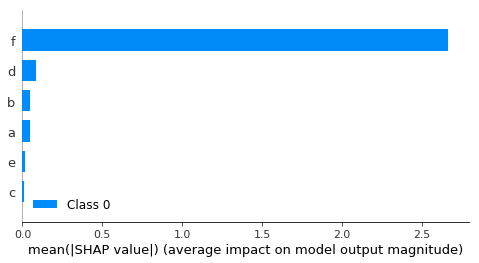

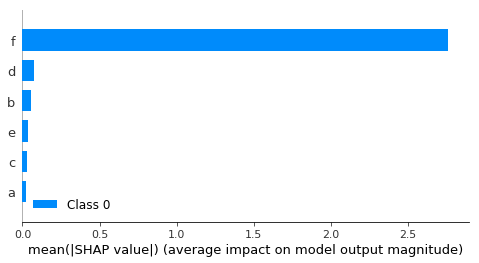

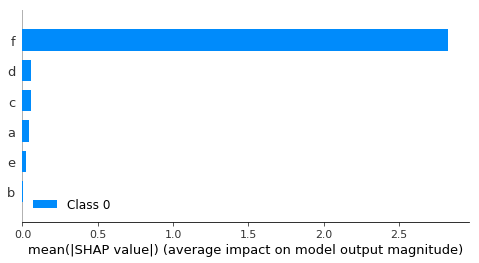

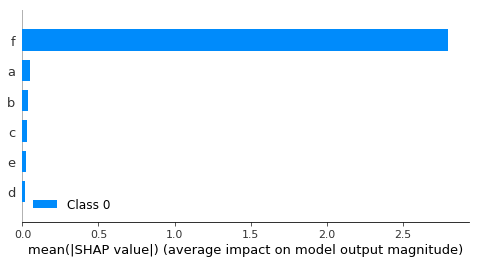

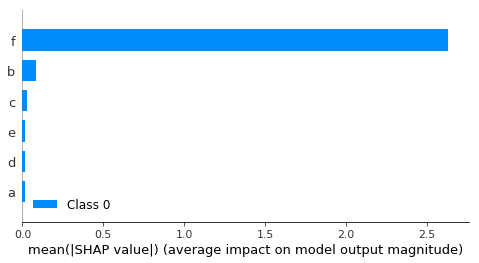

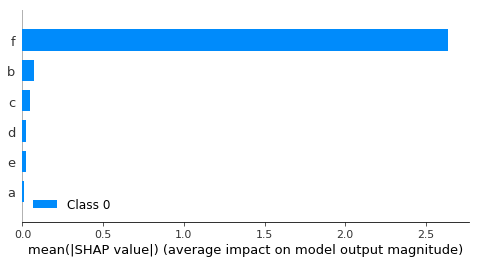

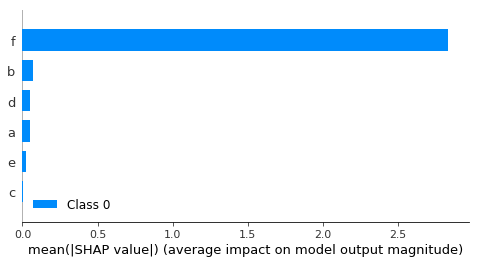

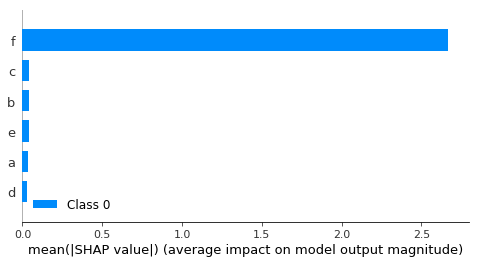

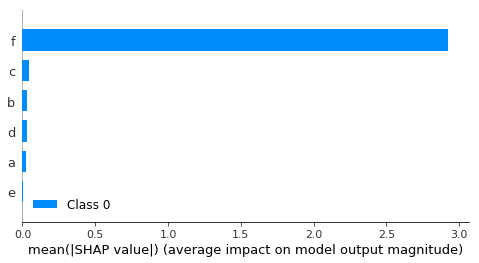

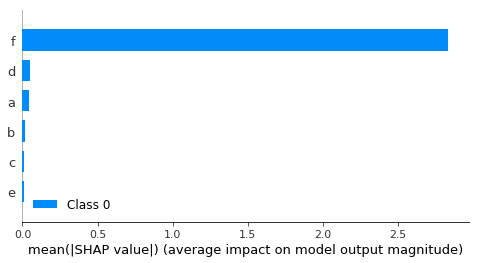

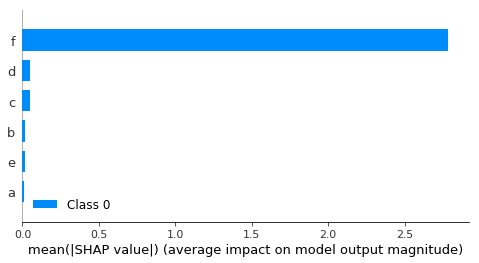

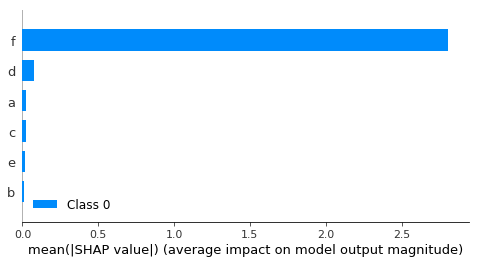

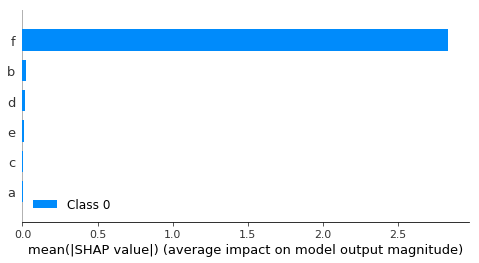

1 2


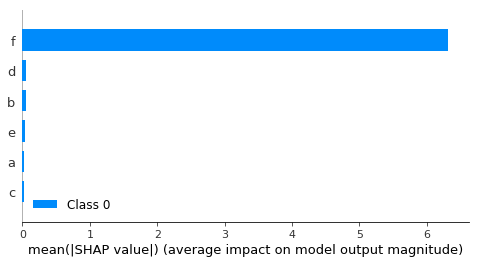

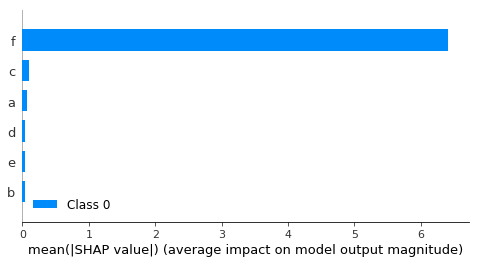

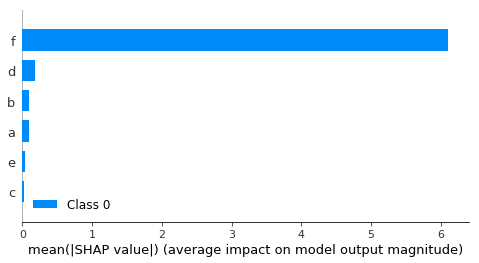

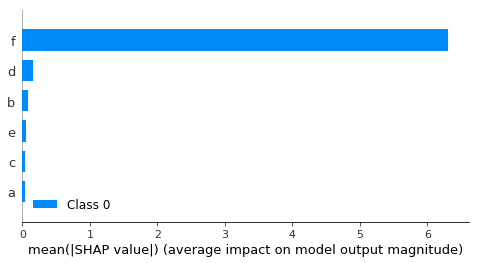

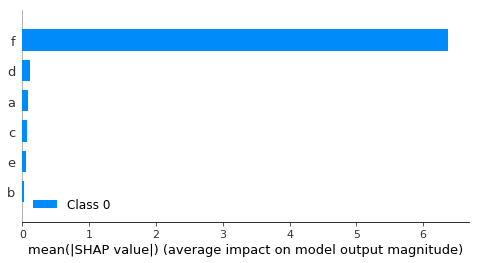

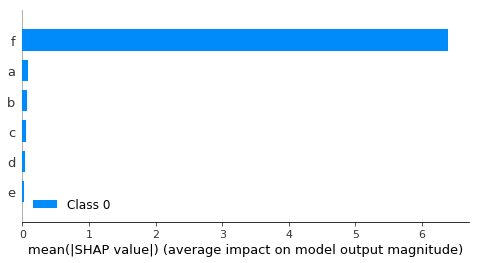

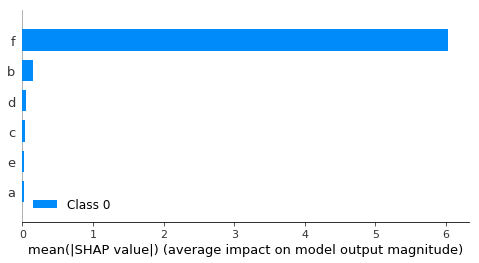

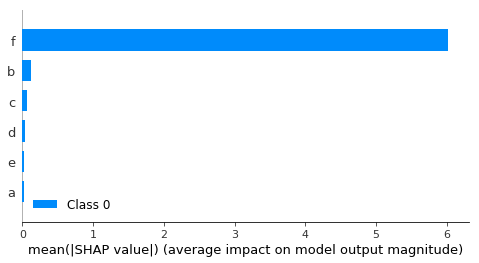

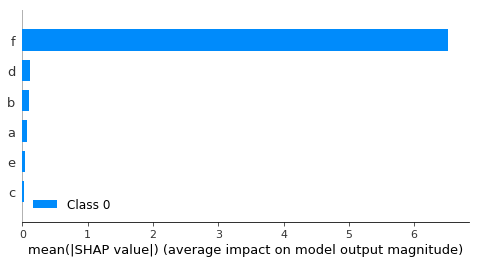

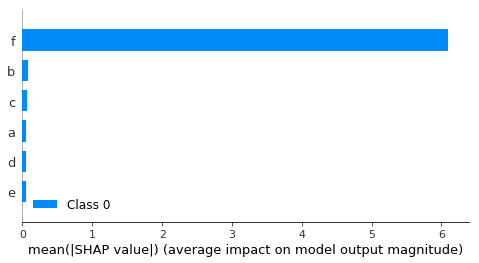

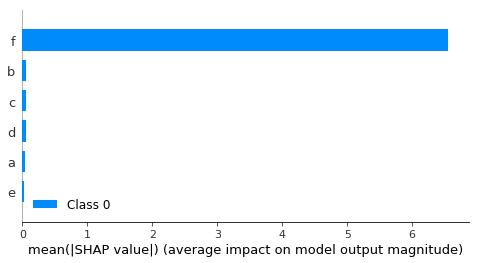

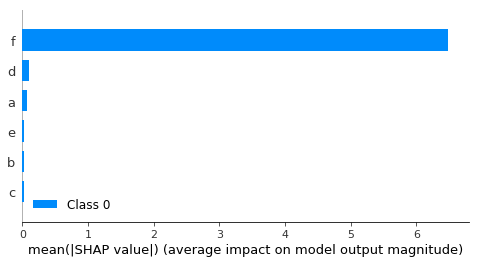

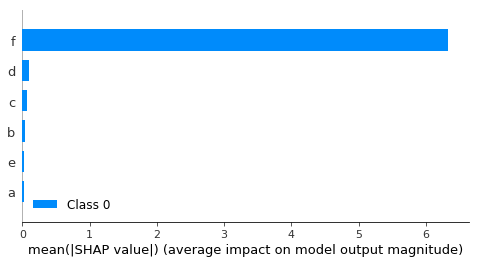

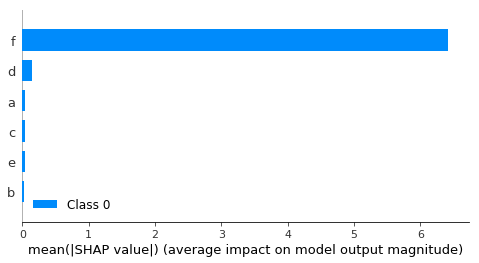

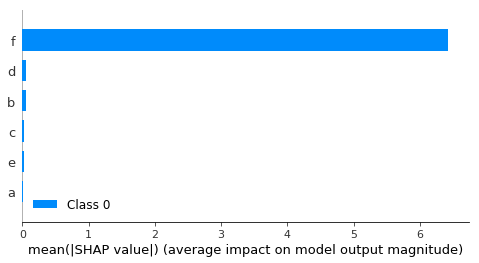

'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

In [28]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1]
variances = [1,2]



import shap
shap.initjs()
def get_shap(df, samples):
    x_train = df[inputs]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 50
base_df = gen_data()
base_shap = get_shap(df, nshap)

# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            #metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = get_shap(x_test2, nshap)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(base_shap, pred_shap))
            test_df2 = pd.DataFrame(x_test2, columns = inputs)
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = target)
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




# USING BIC

In [41]:
#the number of times to sample
times = 2

## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25326.44150356439
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25367.76471265639
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25240.37054526174
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25332.729272581873
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25300.89915686627
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25410.43066520703
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25209.35971283482
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e --> d', 'd --> f', 'f --> g']
-25524.659064149557 -25212.435844641856
['a --> b', 'b --> c', 'b --> d', 'b --> f', 'e -->

Model_name =  temp/e0 Violations =  0.0
Average_violations =  -25576.46158387674 250.020080312348
MSE =  1.0437029002366172 0.007887473234308384
Model_name =  temp/e1 Violations =  0.0
Average_violations =  -25618.902086500504 251.13737384411434
MSE =  1.0480322025872568 0.0025953447801408958
Model_name =  temp/e2 Violations =  0.0
Average_violations =  -25494.704472285935 254.33392702419587
MSE =  1.0749208843203066 0.009140025521298556
Model_name =  temp/e3 Violations =  0.0
Average_violations =  -25581.247990234795 248.51871765292162
MSE =  1.0352081214523785 0.0005132942647225747
Model_name =  temp/e4 Violations =  0.0
Average_violations =  -25545.162473788077 244.2633169218061
MSE =  1.0459836948035561 0.009392964270539372
Model_name =  temp/e5 Violations =  0.0
Average_violations =  -25666.659867617815 256.22920241078464
MSE =  1.0499309334727305 0.0007775879350724324
Model_name =  temp/e6 Violations =  0.0
Average_violations =  -25465.60947632399 256.2497634891715
MSE =  1.06577

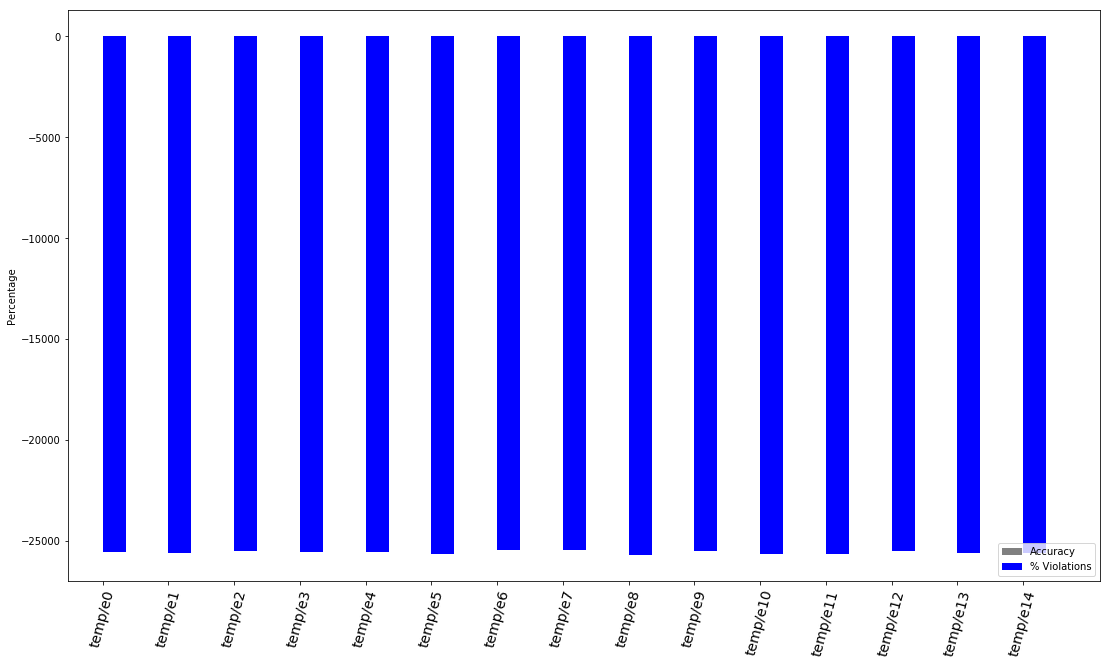

temp/e0
Area under surface (rectangular approx) =  47.13364343910189
Violations =  0.0
Average_violations =  -25576.46158387674
MSE =  1.0437029002366172
temp/e1
Area under surface (rectangular approx) =  46.55437218293055
Violations =  0.0
Average_violations =  -25618.902086500504
MSE =  1.0480322025872568
temp/e2
Area under surface (rectangular approx) =  48.09368706576605
Violations =  0.0
Average_violations =  -25494.704472285935
MSE =  1.0749208843203066
temp/e3
Area under surface (rectangular approx) =  46.96082405214422
Violations =  0.0
Average_violations =  -25581.247990234795
MSE =  1.0352081214523785
temp/e4
Area under surface (rectangular approx) =  47.10049683582648
Violations =  0.0
Average_violations =  -25545.162473788077
MSE =  1.0459836948035561
temp/e5
Area under surface (rectangular approx) =  46.45017353873455
Violations =  0.0
Average_violations =  -25666.659867617815
MSE =  1.0499309334727305
temp/e6
Area under surface (rectangular approx) =  48.47315996729699
Vi

In [42]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
#VIO = np.abs(VIO)
#VIO2 = np.abs(VIO2)


0.9291824452237097


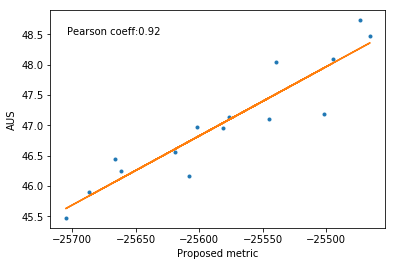

0.41981001846078786


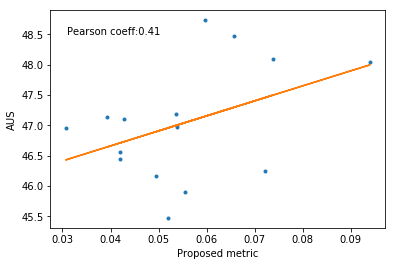

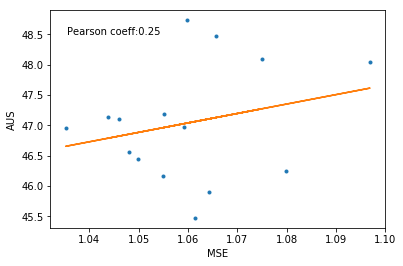

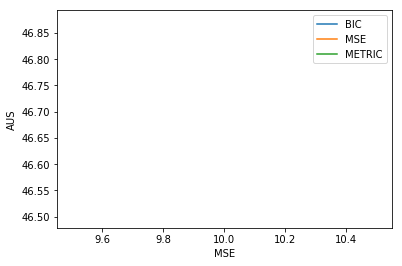

0.41981001846078786

In [43]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

[defaultdict(list,
             {'0_1': [15.784143760746282],
              '0_2': [9.32216185044823],
              '1_1': [15.680897996960022],
              '1_2': [6.346439830947349]}),
 defaultdict(list,
             {'0_1': [15.674899259159778],
              '0_2': [9.156697686964133],
              '1_1': [15.56904294801577],
              '1_2': [6.153732288790864]}),
 defaultdict(list,
             {'0_1': [15.852625635940909],
              '0_2': [9.382176437275179],
              '1_1': [16.069362560697268],
              '1_2': [6.789522431852695]}),
 defaultdict(list,
             {'0_1': [15.68136349191783],
              '0_2': [9.150464939945733],
              '1_1': [15.762590155818245],
              '1_2': [6.36640546446241]}),
 defaultdict(list,
             {'0_1': [15.886614656953983],
              '0_2': [9.425785329181009],
              '1_1': [15.555302646743785],
              '1_2': [6.232794202947709]}),
 defaultdict(list,
             {'0_1': [15.584311416603896],
              '0_2': [9.027815237273101],
              '1_1': [15.639212880768653],
              '1_2': [6.198834004088902]}),
 defaultdict(list,
             {'0_1': [15.917647963096064],
              '0_2': [9.428343210893702],
              '1_1': [16.177616217446293],
              '1_2': [6.949552575860937]}),
 defaultdict(list,
             {'0_1': [16.00720954524862],
              '0_2': [9.590633570192024],
              '1_1': [16.162505444379025],
              '1_2': [6.97184460833805]}),
 defaultdict(list,
             {'0_1': [15.323603278756691],
              '0_2': [8.688037368036278],
              '1_1': [15.51900673884621],
              '1_2': [5.941653591520655]}),
 defaultdict(list,
             {'0_1': [15.815122107305653],
              '0_2': [9.344886922944548],
              '1_1': [16.06423805999278],
              '1_2': [6.814276853002368]}),
 defaultdict(list,
             {'0_1': [15.7260984414321],
              '0_2': [9.414864295256505],
              '1_1': [15.236099054322224],
              '1_2': [5.876032546811534]}),
 defaultdict(list,
             {'0_1': [15.486685005440803],
              '0_2': [8.873235048398431],
              '1_1': [15.531592018223213],
              '1_2': [6.014303074978817]}),
 defaultdict(list,
             {'0_1': [15.825283604731807],
              '0_2': [9.362272614089036],
              '1_1': [15.687238718069525],
              '1_2': [6.317349072074116]}),
 defaultdict(list,
             {'0_1': [15.536056917930965],
              '0_2': [8.877653513043338],
              '1_1': [15.611806607293344],
              '1_2': [6.146213711425738]}),
 defaultdict(list,
             {'0_1': [15.851284805973501],
              '0_2': [9.477253215623616],
              '1_1': [15.523076969046963],
              '1_2': [6.12304878961454]})]

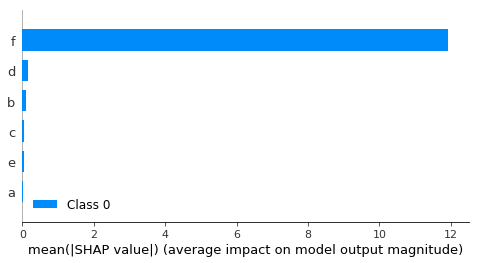

In [15]:
import shap
shap.initjs()
def get_shap(df, samples)
    x_train = df[inputs]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

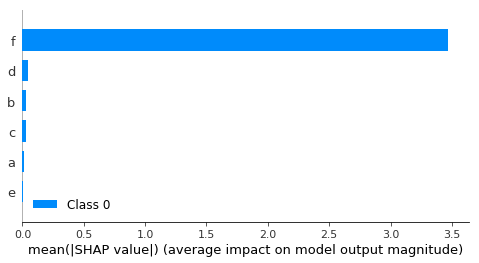

In [9]:
shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)

In [21]:
def get_shap(shap_values):
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

get_shap(shap_values)

[0.02906005082400583,
 0.09948129463888608,
 0.03858441595998082,
 0.1592693918351064,
 0.0314871619804866,
 11.908148576404564]

In [17]:
shap_values[1]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])